# Transfer Learning on Tensorflow

Simple to follow notebook, based on official Tensorflow docs.

In [1]:
# This is to supress all CUDA warnings to make the output cleaner
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
# Import required libraries

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [3]:
print(matplotlib.__version__)
print(tf.__version__)
print(np.__version__)

3.5.2
2.9.0
1.22.4


Now we need our dataset. For this, we will use the cats and dogs dataset.

tf.keras has a function to download files from the internet, and extract them if necessary.

In [4]:
url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# This line downloads the file, and extracts the zip file.
# The download location will be shown later
download_zip_file = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=url, extract=True)

68606236/68606236 [==============================] - 4s 0us/step


In [5]:
file_path = os.path.join(os.path.dirname(download_zip_file), 'cats_and_dogs_filtered')
print(file_path)

/home/ssk/.keras/datasets/cats_and_dogs_filtered


In [6]:
os.listdir(file_path)


['vectorize.py', 'train', 'validation']

In [7]:
# Now that we have the data, we have to create a dataset from it.
# From previous cell, we know the folder structure of the dataset.
img_size = (224, 224)
file_path_train = os.path.join(file_path, 'train')
train_dataset = tf.keras.utils.image_dataset_from_directory(file_path_train, image_size=img_size)

Found 2000 files belonging to 2 classes.


In [8]:
file_path_validation = os.path.join(file_path, 'validation')
validation_dataset = tf.keras.utils.image_dataset_from_directory(file_path_validation,image_size=img_size)

Found 1000 files belonging to 2 classes.


Coming to the pretrained network part

Here we are going to use mobilenet as our pretrained network.

Every network, has some rules for the input layer. It includes image size and normalization.

Keras does this for us, by having function for some pretrained networks

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [10]:
# According to mobileNetV2 documentation, the input shape is 224x224x3.
# We will use this shape for all the images.

img_size = img_size # (224, 224)
img_shape = img_size + (3,)


In [11]:
# Getting our base model

base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape, 
                                               include_top=False, 
                                               weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


Transfer learning begins

In [12]:
# Freezing the entire model
# The weights in the base model won't be changed during model.fit
base_model.trainable = False

In [13]:
# The output layer we want will be a binary classification layer.
# It will have only 1 node

prediction_layer = tf.keras.layers.Dense(1)

In [14]:
# Putting all this together

input = tf.keras.Input(shape=img_shape)
x = preprocess_input(input)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs=input, outputs=outputs)

In [15]:
# Compile the model

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [17]:
loss0, accuracy0 = model.evaluate(validation_dataset, batch_size=32, workers=4)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


32/32 [==============================] - 8s 237ms/step - loss: 0.7317 - accuracy: 0.5530
initial loss: 0.73
initial accuracy: 0.55


Now we train this!

In [18]:
initial_epochs = 10

# Training the model
history = model.fit(train_dataset, epochs=initial_epochs,
                    validation_data=validation_dataset,
                    batch_size=32,
                    workers=4)

Epoch 1/10
63/63 [==============================] - 24s 365ms/step - loss: 0.5990 - accuracy: 0.6445 - val_loss: 0.4687 - val_accuracy: 0.7500
Epoch 2/10
63/63 [==============================] - 24s 377ms/step - loss: 0.3951 - accuracy: 0.8010 - val_loss: 0.3224 - val_accuracy: 0.8680
Epoch 3/10
63/63 [==============================] - 25s 399ms/step - loss: 0.2832 - accuracy: 0.8905 - val_loss: 0.2405 - val_accuracy: 0.9180
Epoch 4/10
63/63 [==============================] - 23s 366ms/step - loss: 0.2188 - accuracy: 0.9400 - val_loss: 0.1912 - val_accuracy: 0.9500
Epoch 5/10
63/63 [==============================] - 23s 365ms/step - loss: 0.1783 - accuracy: 0.9560 - val_loss: 0.1588 - val_accuracy: 0.9610
Epoch 6/10
63/63 [==============================] - 23s 362ms/step - loss: 0.1510 - accuracy: 0.9610 - val_loss: 0.1364 - val_accuracy: 0.9690
Epoch 7/10
63/63 [==============================] - 23s 370ms/step - loss: 0.1319 - accuracy: 0.9670 - val_loss: 0.1200 - val_accuracy: 0.9730

Plotting the model's performance over training time

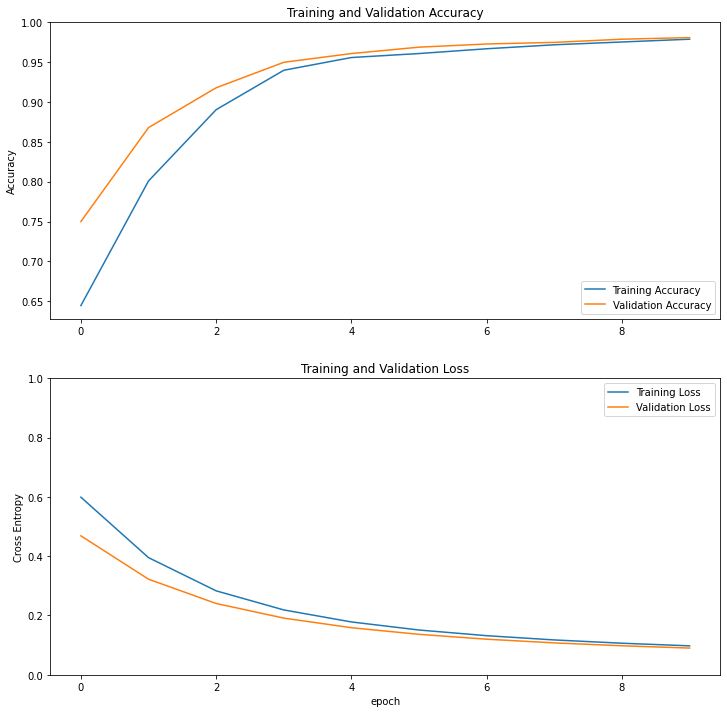

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


Now we have a model that works for our usecase.

We can further improve this model by fine tuning the network.

Here, we unfreeze parts of the netowrk and put them in the training loop --> Fine tuning the layers

In [20]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [21]:
base_model.trainable = True

In [22]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.RMSprop(
              learning_rate=base_learning_rate/10),
              metrics=['accuracy'])


In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [25]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

#Fine-tune the model

# Training the model
history_fine = model.fit(train_dataset,
                    epochs=total_epochs,
                    initial_epoch=history.epoch[-1] + 1, # The epoch number of the last training epoch
                    validation_data=validation_dataset,
                    batch_size=32,
                    workers=4)


Epoch 11/20
63/63 [==============================] - 31s 458ms/step - loss: 0.2646 - accuracy: 0.9190 - val_loss: 0.0638 - val_accuracy: 0.9860
Epoch 12/20
63/63 [==============================] - 30s 476ms/step - loss: 0.1158 - accuracy: 0.9655 - val_loss: 0.0514 - val_accuracy: 0.9850
Epoch 13/20
63/63 [==============================] - 30s 484ms/step - loss: 0.0689 - accuracy: 0.9800 - val_loss: 0.0397 - val_accuracy: 0.9880
Epoch 14/20
63/63 [==============================] - 32s 504ms/step - loss: 0.0445 - accuracy: 0.9890 - val_loss: 0.0303 - val_accuracy: 0.9910
Epoch 15/20
63/63 [==============================] - 30s 478ms/step - loss: 0.0433 - accuracy: 0.9850 - val_loss: 0.0273 - val_accuracy: 0.9900
Epoch 16/20
63/63 [==============================] - 30s 482ms/step - loss: 0.0341 - accuracy: 0.9880 - val_loss: 0.0246 - val_accuracy: 0.9900
Epoch 17/20
63/63 [==============================] - 33s 524ms/step - loss: 0.0199 - accuracy: 0.9960 - val_loss: 0.0241 - val_accuracy:

In [26]:
# Adding our new metrics to the existing history

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


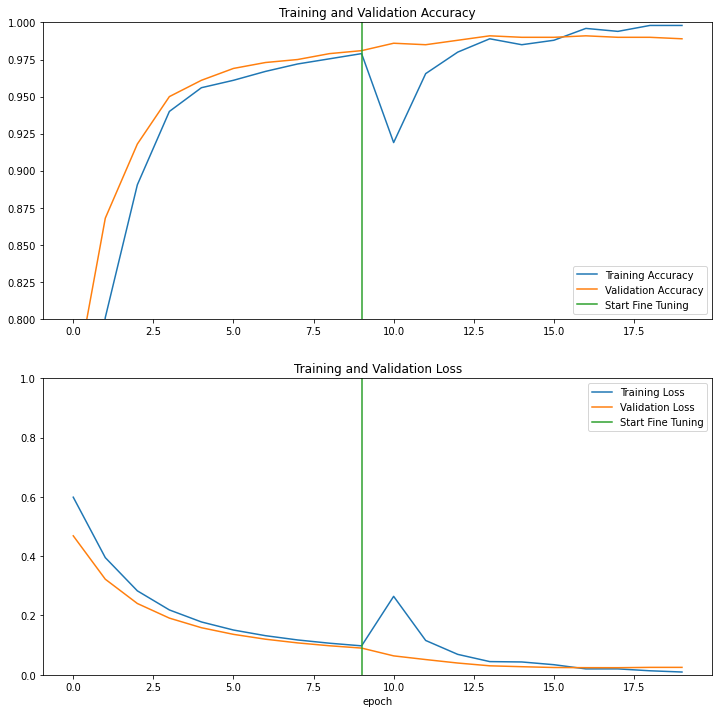

In [27]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


Transfer learning and fine tuning done!